# Constrained Likelihood

In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
#|default_exp likelihood_b

In [3]:
#|export
import jax
import jax.numpy as jnp
from   jax import (jit, vmap)
import genjax
from   genjax import gen, choice_map, vector_choice_map
import matplotlib.pyplot as plt
import numpy as np
import bayes3d
from xsight.utils import *

# console = genjax.pretty(show_locals=False)
key     = jax.random.PRNGKey(0)

In [4]:
#  Data created in "Likelihood Test Data" notebook.
from pathlib import Path

datapath = Path("./data/likelihood_test/")
_data    = {}
for suff in ["1x50", "50x100"]:
    _data[suff] = dict(
        xs = jnp.load(datapath/f"test_Xs_{suff}.npy"),
        ys = jnp.load(datapath/f"test_Ys_{suff}.npy"),
        ps = jnp.load(datapath/f"test_ps_{suff}.npy"))

In [5]:
#|export
import genjax._src.generative_functions.distributions.tensorflow_probability as gentfp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

uniform = genjax.tfp_uniform

truncnormal = gentfp.TFPDistribution(
    lambda mu, sig, low, high: tfd.TruncatedNormal(mu, sig, low, high));

normal = gentfp.TFPDistribution(
    lambda mu, sig: tfd.Normal(mu, sig));

diagnormal = gentfp.TFPDistribution(
    lambda mus, sigs: tfd.MultivariateNormalDiag(mus, sigs));


mixture_of_diagnormals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.MultivariateNormalDiag(mus, sig * jnp.ones_like(mus))))

mixture_of_normals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.Normal(mus, sig * jnp.ones_like(mus))))


mixture_of_truncnormals = gentfp.TFPDistribution(
    lambda ws, mus, sigs, lows, highs: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.TruncatedNormal(mus, sigs, lows, highs)))

[<matplotlib.lines.Line2D object at 0x7fec3939cdf0>]

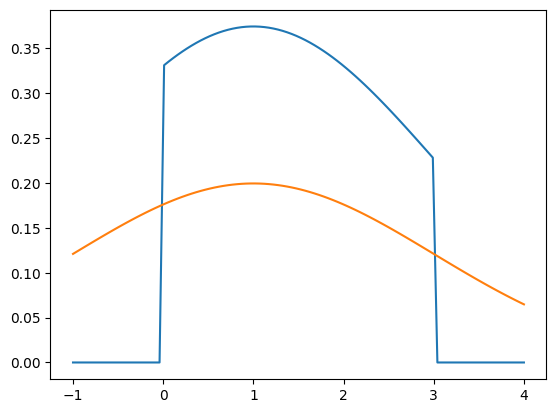

In [6]:
xs = jnp.linspace(-1, 4.0,100)
ys  = vmap(truncnormal.logpdf, (0,None,None,None,None))(xs, 1.0, 2.0, 0.0, 3.0)
ys_ = vmap(normal.logpdf, (0,None,None))(xs, 1.0, 2.0)
plt.plot(xs, jnp.exp(ys))
plt.plot(xs, jnp.exp(ys_))

In [7]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
normal_pdf       = jax.scipy.stats.norm.pdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf


In [8]:
# This function is adapted from `bayes3d.likelihood.gausssian_mixture_vectorize`
# which computes the pixel-wise logprobs in the 3dp3 likelihood.
def threeDP3_logpdf(x, ys, variance, outlier, vol):
    m     = len(ys)
    diffs = x - ys
    logps = jax.scipy.special.logsumexp( 
        jax.scipy.stats.norm.logpdf(
            diffs,
            loc   = 0.0,
            scale = jnp.sqrt(variance)
        ).sum(-1) - jnp.log(m)
    )
    return jnp.logaddexp(jnp.log(1.0 - outlier) + logps, jnp.log(outlier) - jnp.log(vol))

## 1D Mixture Components

In [9]:
#|export

def get_projections_and_distances(x, ys):
    """Returns projections and distances of y's on and to ray through x."""
    
    z   = jnp.linalg.norm(x, axis=-1)
    zs_ = jnp.linalg.norm(ys, axis=-1)

    # Projections ONTO ray through `x`
    ys_ = ys @ x / z
    
    # Distances TO ray through `x`
    ds_ = jnp.sqrt(zs_**2 - ys_**2)

    return ys_, ds_

In [10]:
#|export
def get_1d_mixture_components(x, ys, sig):
    """Returns 1d mixture components and thier unnormalized weights."""

    # Projections serve as 1d mixture components and 
    # distances will be turned into appropriate weights
    ys_, ds_ = get_projections_and_distances(x, ys)    

    # Transform weights appropriately.
    ws_  = normal_logpdf(ds_, loc=0.0, scale=sig) + normal_logpdf(0.0, loc=0.0, scale=sig)

    return ys_, ws_

In [11]:
def plot_circle(x, r=1.0, ax=None, **kwargs):
    if ax is None: ax=plt.gca()

    ts = jnp.linspace(0,jnp.pi*2,50)
    ax.plot(x[0] + r*jnp.cos(ts), x[1] + r*jnp.sin(ts), **kwargs)

In [12]:
# def pix_angle(i):
#     # alpha = jnp.arctan2(i+1,1) -  jnp.arctan2(i-1,1)
#     alpha = jnp.arctan2(i,1) -  jnp.arctan2(i-1,1)
#     return alpha

def pix_angle(i, near=1):
    a0 = jnp.arctan2(i,near)     -  jnp.arctan2(i-0.5,near)
    a1 = jnp.arctan2(i+0.5,near) -  jnp.arctan2(i,near)
    return a0,a1

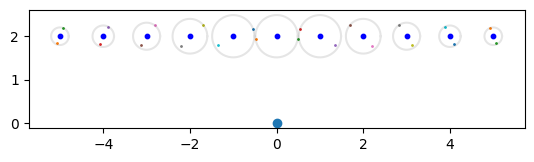

In [13]:
xs = jnp.arange(-5,5+1)
near = 2

plt.scatter(0,0)
plt.scatter(xs, near*jnp.ones_like(xs), s=10, c="b")

plt.gca().set_aspect(1)
for x in xs:
    y = jnp.array([x,near])
    z = jnp.linalg.norm(y)
    a = jnp.arctan2(near, x)

    a0, a1 = pix_angle(x, near)
    v0 = z*jnp.array([jnp.cos(a+a0),jnp.sin(a+a0)])
    v1 = z*jnp.array([jnp.cos(a-a1), jnp.sin(a-a1)])

    # r = jnp.linalg.norm(v0 - v1)/2
    r = jnp.maximum(jnp.linalg.norm(v0-y),jnp.linalg.norm(v1-y))

    plt.scatter(v0[0], v0[1],s=1)
    plt.scatter(v1[0], v1[1],s=1)
    plot_circle(y, r, c="k", alpha=0.1)

(31, 50, 2)
-25.0 25.0


[<matplotlib.lines.Line2D object at 0x7fec39014940>]

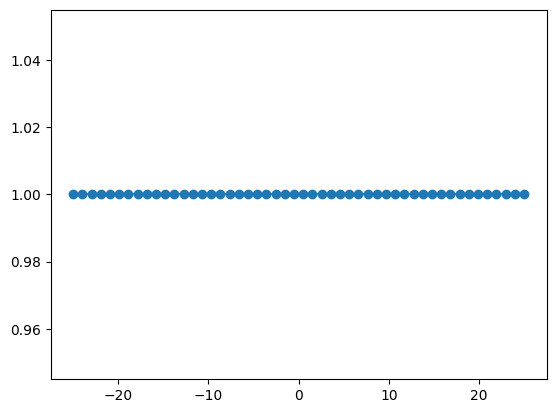

In [14]:
_ps = _data["1x50"]["ps"][:,:3]
_xs = jnp.stack(_data["1x50"]["xs"][:,0,:,[0,2]], axis=-1)
_ys = jnp.stack(_data["1x50"]["ys"][:,0,:,[0,2]], axis=-1)


print(_ys.shape)
# Pixels on on canvas `[-w/2, w/2] x [-h/2,h/2]`, where
# `w,h` are the width and height in pixels. This comes from 
# how the renderer works, the ys alone don't carry that infromation.
# We just assume they come from Nishad's renderer. 
_pixs = _ys[0,:,0]/_ys[0,:,1]
_pixs *= _ys.shape[1]/(jnp.max(_pixs) - jnp.min(_pixs))

print(jnp.min(_pixs),jnp.max(_pixs))
plt.plot(_pixs, jnp.ones_like(_pixs), marker="o")


In [15]:

pixs = jnp.arange(i-w-25,i+w+1-25)
pixs,pixs[w]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1915/1559473169.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1915/1559473169.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'i' is not defined

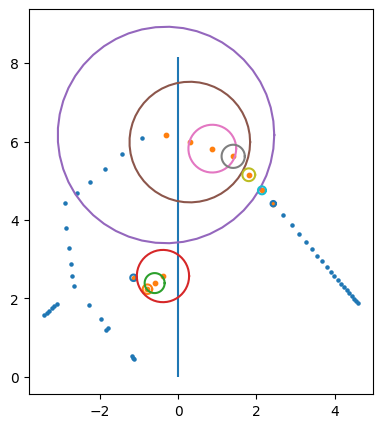

In [16]:
_ps = _data["1x50"]["ps"][:,:3]
_xs = jnp.stack(_data["1x50"]["xs"][:,0,:,[0,2]], axis=-1)
_ys = jnp.stack(_data["1x50"]["ys"][:,0,:,[0,2]], axis=-1)


t = 20
i = 25
w = 5

ys = _xs[t,i-w:i+w+1]

pixs = jnp.arange(i-w-24,i+w+1-24)


x  = jnp.array([0,1])

zs_ = jnp.linalg.norm(ys, axis=-1)
ys_, ds_ = get_projections_and_distances(x, ys)


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_aspect(1)
ax.vlines(0,0,jnp.max(ys[:,1])+2)
ax.scatter(*_ys[t].T, s=5)
ax.scatter(*ys.T, s=10)

def pix_angle(i):
    a0 = jnp.arctan2(i,1)     -  jnp.arctan2(i-0.5,1)
    a1 = jnp.arctan2(i+0.5,1) -  jnp.arctan2(i,1)
    # a = jnp.maximum(a0,a1)
    return a0,a1

# ax.scatter(ds_, ys_)
for y,z,d,px in zip(ys, zs_,ds_, pixs):

    a0,a1 = pix_angle(px)
    vv = jnp.array([
        jnp.cos(a0) - jnp.cos(-a1),
        jnp.sin(a0) - jnp.sin(-a1)
    ])
    r = jnp.linalg.norm(z*vv)/2
    plot_circle(y, r, ax=ax)


[<matplotlib.lines.Line2D object at 0x7fec35ee9ea0>]

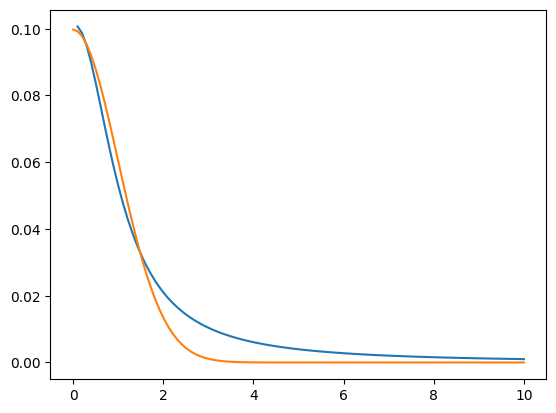

In [17]:
xs = jnp.linspace(0,10,100)

plt.plot(xs[1:],jnp.arctan2(xs[1:],1) - jnp.arctan2(xs[:-1],1))
plt.plot(xs, 1/0.4*0.1*vmap(jax.scipy.stats.norm.pdf)(xs))

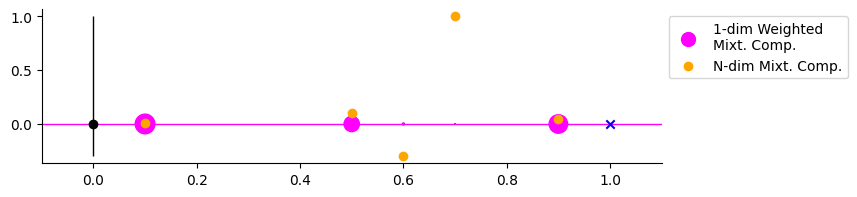

In [18]:
sig  = .1
zmax = 1.

xs = zmax*jnp.linspace(0.0,1.0,1000)[:,None]*jnp.array([0.0, 0.0, 1.0])
x  = xs[-1]
ys = zmax*jnp.array([ 
    [.01, 0., .1],
    [0.1, 0, .5],
    [-.3, 0, .6],
    [1, 0, .7],
    [.05, 0, .9],
])

ds, ws = get_1d_mixture_components(x, ys, sig)
d  = jnp.linalg.norm(x)
ws = ws - logsumexp(ws, axis=-1)

# ------------------------------
fig, ax = plt.subplots(1,1, figsize=(8,2), sharex=True)
ax.set_xlim(-0.1*zmax,1.1*zmax)
ax.scatter(ds, jnp.zeros(len(ds)),  s=jnp.exp(ws)*500, c="magenta", label="1-dim Weighted\nMixt. Comp.")
ax.scatter(d, x[0],marker="x", c="blue");
ax.hlines(0, -0.1*zmax,1.1*zmax, color="magenta", zorder=-1, linewidth=1.)
ax.scatter(ys[:,2], ys[:,0], c="orange", label="N-dim Mixt. Comp.")
ax.vlines(0, jnp.min(ys[:,0]), jnp.max(ys[:,0]), color="k", zorder=-1, linewidth=1.)
ax.scatter(0,0, c="k")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Reality Checks 

Comparing the constrained 1d mixture with restricted 3d mixture and Nishad's 3dp3 likelihood.

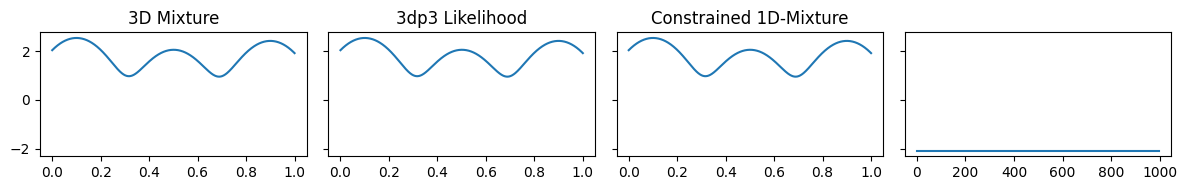

In [19]:
sig = .1

# Baseline of 3D-Mixture
ws0 = jnp.zeros(len(ys)) - jnp.log(len(ys))
ps0 = vmap(lambda x: 
            mixture_of_diagnormals.logpdf(x, ws0, ys, sig)
      )(xs)

# 3dp3 Likelihood
ps1 = vmap(lambda x: threeDP3_logpdf(x, ys, sig**2, 0.0, 1.0))(xs)


# Constrained 1D-Mixture
ds, ws = get_1d_mixture_components(xs[-1], ys, sig)
offset = logsumexp(ws) - jnp.log(len(ws))
ps2 = vmap(lambda x: 
            mixture_of_normals.logpdf(x, ws, ds, sig)
      )(jnp.linalg.norm(xs, axis=-1))
ps2 += offset


# =======================================
fig, axs = plt.subplots(1,4, figsize=(12,2), sharey=True)
axs[0].set_title("3D Mixture")
axs[0].plot(jnp.linalg.norm(xs, axis=-1), ps0)
axs[1].set_title("3dp3 Likelihood")
axs[1].plot(jnp.linalg.norm(xs, axis=-1), ps1)
axs[2].set_title("Constrained 1D-Mixture")
axs[2].plot(jnp.linalg.norm(xs, axis=-1), ps2)
axs[3].plot(ps0 - ps2- offset);
fig.tight_layout()

In [20]:
sig = 0.2
x = jnp.array(np.random.randn(3))
y = jnp.array(np.random.randn(3))

d  = jnp.linalg.norm(x)
y_ = y@x/d
w_ = jnp.linalg.norm(y_*x/d - y)


assert jnp.allclose(
    diagnormal.logpdf(x, y, sig*jnp.ones_like(y)),
    normal.logpdf(d, y_, sig) + normal.logpdf(w_, 0, sig) + normal.logpdf(0.0, 0.0, sig),
)

In [21]:
def allclose(*vs, **kwargs):
    v0 = vs[0]
    return jnp.all(jnp.array([
        jnp.allclose(v0,v, **kwargs) for v in vs[1:]
    ]))

In [22]:
from functools import reduce
sig = 0.2

x  = jnp.array(np.random.randn(3))
ys = jnp.array(np.random.randn(20,3))

d   = jnp.linalg.norm(x)
ys_ = jnp.dot(ys,x) / d
ws_ = jnp.linalg.norm(ys_[:,None]*x[None]/d - ys, axis=-1)
ws_ = normal_logpdf(ws_, 0.0, sig) + normal_logpdf(0.0, 0.0, sig)



assert allclose(
    mixture_of_diagnormals.logpdf(x, jnp.zeros(len(ys)), ys, sig), 

    logsumexp(jnp.array([
        diagnormal.logpdf(x, y, sig*jnp.ones_like(y)) for y in ys
    ])) - jnp.log(len(ys)),

    logsumexp(jnp.array([
        normal_logpdf(d, y_, sig) + w_ for y_,w_ in zip(ys_, ws_)
    ])) - jnp.log(len(ys)),

    mixture_of_normals.logpdf(d, ws_, ys_, sig) + logsumexp(ws_) - jnp.log(len(ys))
)

## Constrained Likelihood Model

In [23]:
#|export
# Some helper to keep code concise
min = jnp.minimum
max = jnp.maximum


def dslice(X, i, j, w):     
    m = 2*w + 1
    return  jax.lax.dynamic_slice(X, (i, j, 0), (m, m, 3))   


def pad(X, w, val=-100.0):
    return jax.lax.pad(X,  val, ((w,w,0),(w,w,0),(0,0,0)))


def mix_std(ps, mus, stds):
    """Standard Deviation of a mixture of Gaussians."""
    return jnp.sqrt(jnp.sum(ps*stds**2) + jnp.sum(ps*mus**2) - (jnp.sum(ps*mus))**2)

In [46]:
#|export

def clip_depth(y, zmax):
    d     = jnp.linalg.norm(y[...,:3], axis=-1, keepdims=True)
    zmax_ = d/y[...,[2]]*zmax
    d_    = jnp.clip(d, 0.0, zmax_)
    return y[...,:3]/d*d_

In [426]:
#|export
def get_projections_and_distances(x, ys):
    """Returns projections and distances of y's on and to ray through x."""
    
    z   = jnp.linalg.norm(x, axis=-1)
    zs_ = jnp.linalg.norm(ys, axis=-1)

    # Projections ONTO ray through `x`
    ys_ = ys @ x / z
    
    # Distances TO ray through `x`
    ds_ = jnp.linalg.norm(ys_[:,None] * x / z - ys, axis=-1)

    return ys_, ds_

In [427]:
#|export
def get_1d_mixture_components_b(x, ys, sig):
    """Returns 1d mixture components and thier unnormalized weights."""

    # Projections serve as 1d mixture components and 
    # distances will be turned into appropriate weights
    ys_, ds_ = get_projections_and_distances(x, ys)    

    # Transform weights appropriately.
    ws_  = normal_logpdf(ds_, loc=0.0, scale=sig) + normal_logpdf(0.0, loc=0.0, scale=sig)

    return ys_, ws_

In [428]:
jnp.concatenate([jnp.zeros(1), jnp.cumsum(jnp.arange(3))])

Array([0., 0., 1., 3.], dtype=float32)

In [512]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_constrained_sensor_model(zmax, w, return_mean=True):
    """Returns an (untruncated) constrained sensor model marginalized over outliers."""    

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y = Y_[i+w,j+w] 
        d = jnp.linalg.norm(y, axis=-1)
        
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        ds = jnp.linalg.norm(ys, axis=-1)

        ys_, ds_ = get_projections_and_distances(y, ys)  
        
        zmax_ = d/y[2]*zmax

        # sig_focus = zmax/2
        # sigs = ds/sig_focus*sig
        sigs = sig
        
        ws_ = normal_logpdf(ds_, loc=0.0, scale=sigs) 
        ws_ = ws_ - logsumexp(ws_)



        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_truncnormals, genjax.tfp_uniform])

        # Adjustment weights to make up for 
        # the difference to the 3dp3 model
        # adj = logsumexp(ws_) - jnp.log(len(ws_))

        # NOTE: To compare to baseline one should set: `zmax_ = zmax``
        

        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws_, ys_, sigs, 0.0, zmax_), 
                                    (0.0, zmax_))) @ "measurement"

        # z = jnp.clip(z, 0.0, zmax_)

        return z * y/d
        
    @gen
    def sensor_model(Y, sig, outlier):   
        """
        Constrained sensor model that returns a vector of range measurements conditioned on 
        an image, noise level, and outlier probability.
        """
        shape = (Y.shape[0]-2*w, Y.shape[1]-2*w)
        I, J  = jnp.mgrid[:shape[0], :shape[1]]
        I, J  = I.ravel(), J.ravel()
                
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y[:,:,:3], sig, outlier) @ "X"
        X = X.reshape(*shape, 3)
        return X

    return sensor_model

In [513]:
suff = "50x100"
Y = _data[suff]["ys"][3]
Y.shape

(50, 100, 4)

0.61223346 10.0
0.54662955 9.999847


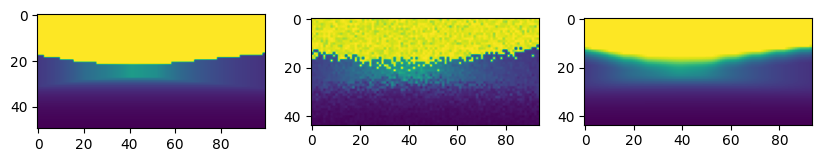

In [518]:
zmax = 10.
w    = 3
sig  = 0.3
out  = 0.0

sensor_model = make_constrained_sensor_model(zmax, w)
key = keysplit(key)
X, mu = sensor_model(Y, sig, out)(key)

print(jnp.min(Y[:,:,2]),jnp.max(Y[:,:,2]))
print(jnp.min(X[:,:,2]),jnp.max(X[:,:,2]))

fig, axs = plt.subplots(1,3, figsize=(10,4))
axs[0].imshow(Y[:,:,2])
axs[1].imshow(X[:,:,2])
axs[2].imshow(mu[:,:,2])

In [14]:
#|export
def get_data_logprobs(tr):
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

## Blurred Likelihood Model - V2

In [15]:
#|export
def get_gaussian_blurr_weights(x, ys, sig_pix=5):
    """Gaussian blurr weights"""

    # Projections serve as 1d mixture components
    ys_ = ys @ x / jnp.linalg.norm(x, axis=-1)

    # Pixels on on canvas `[-w/2, w/2] x [-h/2,h/2]`, where
    # `w,h` are the width and height in pixels. This comes from 
    # how the renderer works, the ys alone don't carry that infromation.
    # We just assume they come from Nishad's renderer. 
    pixs   = ys/ys[:,[2]]*(100/2)
    center = x/x[2]*(100/2)
    
    # Compute gaussian blurr weights
    ds_ = jnp.linalg.norm(pixs[:,:2] - center[:2], axis=-1)
    ws_ = normal_logpdf(ds_, loc=0.0, scale=sig_pix)

    return ys_, ws_

In [16]:
#  Data created in "Likelihood Test Data" notebook.
# suff = "1x50"
suff = "50x100"
Xs = jnp.load(f"./data/test_Xs_{suff}.npy")
Ys = jnp.load(f"./data/test_Ys_{suff}.npy")
ps = jnp.load(f"./data/test_ps_{suff}.npy")

Xs.shape, Ys.shape

((101, 50, 100, 4), (101, 50, 100, 4))

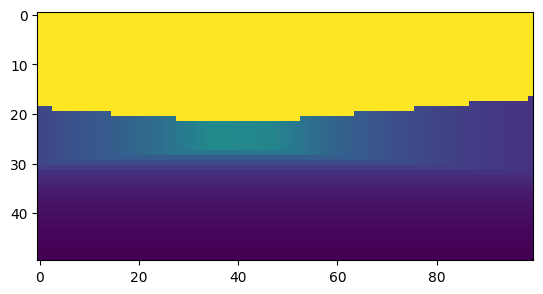

In [17]:
Y = Ys[0]
plt.imshow(Y[:,:,2], vmax=10)

(11, 11, 3)


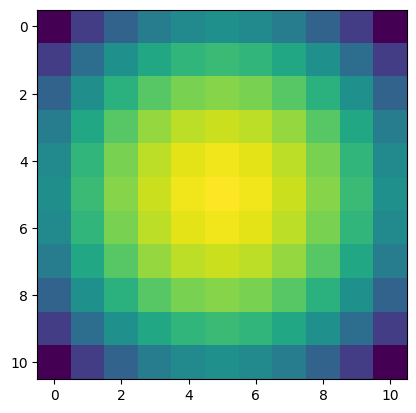

In [19]:


i,j=5,1
w = 5
ys = dslice(Y[:,:,:3], i, j, w)
print(ys.shape)

plt.imshow(ys[:,:,2], vmin=0, vmax=10)
ys = ys.reshape(-1,3)
y  = Y[i+w,j+w,:3]
ys_, ws_ =  get_gaussian_blurr_weights(y, ys, w)

plt.imshow(ws_.reshape(2*w+1,2*w+1))

In [20]:
x  = x/jnp.linalg.norm(x)
ys = ys/jnp.linalg.norm(ys, axis=-1, keepdims=True)
(x@ys.T).shape
x@ys.T

Array([0.39586523, 0.4034517 , 0.41120285, 0.41912127, 0.42720914,
       0.43546867, 0.4439017 , 0.45250967, 0.46129373, 0.47025454,
       0.47939238, 0.3974113 , 0.40508854, 0.4129355 , 0.42095485,
       0.42914927, 0.43752107, 0.44607234, 0.45480496, 0.46372026,
       0.47281927, 0.4821026 , 0.3988727 , 0.40663782, 0.41457734,
       0.42269447, 0.43099213, 0.4394728 , 0.44813886, 0.45699254,
       0.46603557, 0.47526905, 0.48469412, 0.4002457 , 0.4080953 ,
       0.41612396, 0.4243353 , 0.4327323 , 0.4413181 , 0.4500951 ,
       0.45906582, 0.4682324 , 0.47759634, 0.48715883, 0.4015263 ,
       0.40945655, 0.4175707 , 0.4258724 , 0.43436486, 0.44305143,
       0.45193505, 0.46101847, 0.47030398, 0.47979355, 0.48948857,
       0.4027108 , 0.41071796, 0.4189134 , 0.4273011 , 0.43588454,
       0.44466746, 0.45365295, 0.462844  , 0.47224346, 0.48185337,
       0.49167556, 0.4037956 , 0.41187537, 0.42014778, 0.4286168 ,
       0.43728656, 0.44616076, 0.4552429 , 0.4645363 , 0.474044  ,
       0.48376858, 0.493712  , 0.40477726, 0.41292506, 0.42126969,
       0.42981523, 0.43856603, 0.44752628, 0.45669943, 0.46608943,
       0.47569934, 0.4855321 , 0.4955902 , 0.40565237, 0.41386354,
       0.42227533, 0.43089223, 0.4397187 , 0.44875908, 0.4580174 ,
       0.4674976 , 0.4772031 , 0.48713732, 0.49730283, 0.4064179 ,
       0.4146874 , 0.42316106, 0.43184382, 0.44074002, 0.4498546 ,
       0.45919168, 0.46875536, 0.4785496 , 0.48857787, 0.4988432 ,
       0.407071  , 0.41539353, 0.4239236 , 0.4326662 , 0.44162625,
       0.4508084 , 0.46021736, 0.4698575 , 0.47973296, 0.48984745,
       0.5002044 ], dtype=float32)

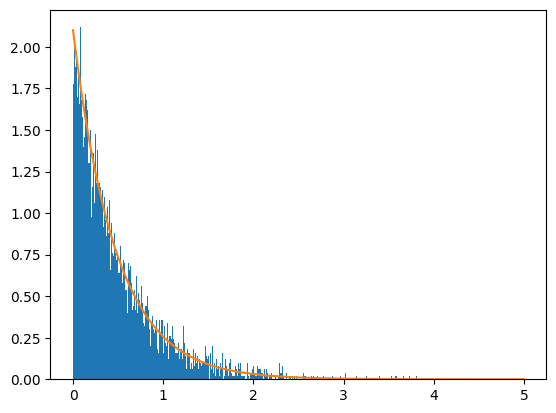

In [67]:
key = keysplit(key)
lam = 2.1
bins = jnp.linspace(0,5,1000)
db = bins[1] - bins[0]
plt.hist(1/lam*vmap(jax.random.exponential)(keysplit(key,10_000)),  bins=bins, density=True);
plt.plot(bins,lam*vmap(jnp.exp)(-lam*bins));

In [75]:
from genjax._src.generative_functions.distributions.distribution import ExactDensity

class Exponential(ExactDensity):
    def sample(self, key, lam):
        return 1/lam*jax.random.exponential(key)

    def logpdf(self, x, lam):
        return jnp.log(lam) - lam*x

exponential = Exponential()


[<matplotlib.lines.Line2D object at 0x7fbaf6db95d0>]

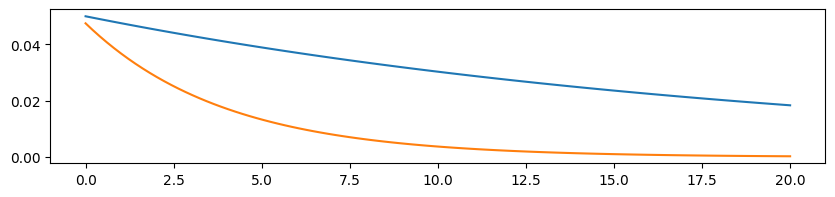

In [130]:
key, (k1,k2) = keysplit(key,1,2)

bins = jnp.linspace(0,20,100)
lam = 1/bins[-1]
db = bins[1] - bins[0]


plt.figure(figsize=(10,2))
# plt.hist([
#         1/lam*vmap(jax.random.exponential)(keysplit(k1,10_000)),
#         vmap(exponential(lam))(keysplit(k2,10_000))
#     ],  bins=bins, density=True);
# plt.plot(bins,lam*vmap(jnp.exp)(-lam*bins));
# plt.plot(bins, jnp.exp(vmap(exponential.logpdf, (0,None))(bins, lam)));

ps = jnp.ones(len(bins))*lam
plt.plot(bins,lam*vmap(jnp.exp)(-lam*bins));
plt.plot(bins, jnp.cumprod(1-ps)*ps)
# plt.plot(bins, ps)

In [2]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_blurred_sensor_model(zmax, w):
    """Returns an symbolic gaussian blurred sensor model (marginalized over outliers)."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w]
        d  = jnp.linalg.norm(y, axis=-1)
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        ys_, ws_ =  get_gaussian_blurr_weights(y, ys, w)

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_normals, genjax.tfp_uniform])


        # NOTE: To compare to baseline one should set: `zmax_ = zmax``
        zmax_ = d/y[2]*zmax
        # zmax_ = zmax
        
        # mix_std(ps, mus, stds)
        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws_, ys_, sig), 
                                    (0.0, zmax_))) @ "measurement"

        z = jnp.clip(z, 0.0, zmax_)
        
        return z * y/d

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """
        Constrained sensor model that returns a vector of range measurements conditioned on 
        an image, noise level, and outlier probability.
        """
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"

        X = X.reshape(Y.shape)

        return X

    return sensor_model

In [1]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_blurred_sensor_model_2(zmax, w):
    """Returns an symbolic gaussian blurred sensor model (marginalized over outliers)."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w]
        d  = jnp.linalg.norm(y, axis=-1)
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        ys_, ws_ =  get_gaussian_blurr_weights(y, ys, w)

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                normal, genjax.tfp_uniform])


        # NOTE: To compare to baseline one should set: `zmax_ = zmax``
        zmax_ = d/y[2]*zmax
        # zmax_ = zmax
        
        ws_ = ws_ - logsumexp(ws_)
        std = mix_std(jnp.exp(ws_), ys_, jnp.ones_like(ys_)*sig)
        mu  = jnp.sum(ys_*jnp.exp(ws_))
        
        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (mu, sig), 
                                    (0.0, zmax_))) @ "measurement"

        z = jnp.clip(z, 0.0, zmax_)
        
        return z * y/d

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """
        Constrained sensor model that returns a vector of range measurements conditioned on 
        an image, noise level, and outlier probability.
        """
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"

        X = X.reshape(Y.shape)

        return X

    return sensor_model

## Binary Likelihood Model - V3

In [ ]:
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_binary_sensor_model(zmax, w):
    """Returns an symbolic gaussian blurred sensor model (marginalized over outliers)."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w]
        d  = jnp.linalg.norm(y, axis=-1)
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        ys_, ws_ =  get_gaussian_blurr_weights(y, ys, w)

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_normals, genjax.tfp_uniform])

        # Adjustment weights to make up for 
        # the difference to the 3dp3 model
        adj = logsumexp(ws_) - jnp.log(len(ws_))

        # NOTE: To compare to baseline one should set: `zmax_ = zmax``
        # zmax_ = d/y[2]*zmax
        zmax_ = zmax
        
        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws_, ys_, sig), 
                                    (0.0, zmax_))) @ "measurement"

        
        return z * y/d, adj

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """
        Constrained sensor model that returns a vector of range measurements conditioned on 
        an image, noise level, and outlier probability.
        """
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X, W = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        W = W.reshape(Y.shape[:2])
        X = X.reshape(Y.shape)

        return X, W

    return sensor_model

## Explicit 3DP3 Baseline Model

Explicit version of the 3dp3 likelihood model. So we have access to the individual probabilities of each pixel.

In [21]:
#|export
from bayes3d.likelihood import threedp3_likelihood_old
from genjax.generative_functions.distributions import ExactDensity
from xsight.mixtures import HeterogeneousMixture


class ThreeDP3Outlier(ExactDensity):
    def sample(self, key, y, zmax):
        u = zmax*jax.random.uniform(key)
        return u*y

    def logpdf(self, x, y, zmax):
        # We assume here that x and y linearly dependent.
        y_ = y/jnp.linalg.norm(y)
        u  = jnp.dot(x,y_)
        return genjax.tfp_uniform.logpdf(u, 0.0, zmax)


threedp3_outlier = ThreeDP3Outlier()

In [1]:
#|export
def make_baseline_sensor_model(zmax, w):
    """Explicit version of the 3dp3 sensor model."""
  
    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w] 
        ys = dslice(Y_, i, j, w).reshape(-1,3)

        inlier_outlier_mix = HeterogeneousMixture([mixture_of_diagnormals, threedp3_outlier])

        d = jnp.linalg.norm(y)
        zmax_ = d/y[2]*zmax
        # zmax_ = zmax

        m = len(ys)
        x = inlier_outlier_mix(jnp.array([1.0-outlier, outlier]), (
                                    (jnp.zeros(m), ys, sig), 
                                    (y, zmax_))) @ "measurement"

        z  = jnp.linalg.norm(x)
        z_ = jnp.clip(z, 0.0, zmax_)

        return z_*x/z, None

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X,_ = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        X = X.reshape(Y.shape)

        return X, None

    return sensor_model

### Baseline reality check

Here we are making sure the baseline is indeed that same as the 3dp3 likelihood.

In [28]:
zmax = 50.
w    = 7

baseline_model = make_baseline_sensor_model(zmax, w)

def _eval_baseline(X, Y, sig, outlier):
    obs = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement": X[:,:,:3].reshape(-1,3)
            }) 
    })
    args = (Y[:,:,:3], sig, outlier)
    w, tr = baseline_model.importance(key, obs, args)
    logps = get_data_logprobs(tr).reshape(X.shape[:2])
    return tr.get_score(), logps


eval_baseline = jit(vmap(_eval_baseline, (None, 0, None, None)))

In [23]:
#  Data created in "Likelihood Test Data" notebook.
# suff = "1x50"
suff = "50x100"
Xs = jnp.load(f"./data/test_Xs_{suff}.npy")
Ys = jnp.load(f"./data/test_Ys_{suff}.npy")
ps = jnp.load(f"./data/test_ps_{suff}.npy")

Xs.shape, Ys.shape

((101, 50, 100, 4), (101, 50, 100, 4))

In [30]:
sig     = 0.1
outlier = 0.2


X = Xs[0]
a, _ = eval_baseline(X, Xs, sig, outlier)
c = jnp.array([threedp3_likelihood(X, Y, sig**2, outlier, zmax, w) for Y in Xs])

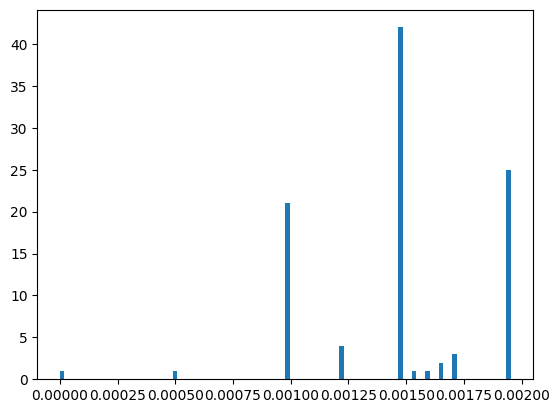

In [31]:
# _, bins, _ = plt.hist(a-c, bins=jnp.linspace(-5,5,100));
_, bins, _ = plt.hist(a-c, bins=100);


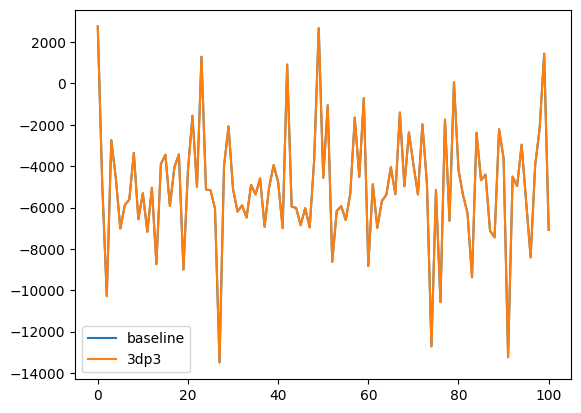

In [32]:
plt.plot(a, label="baseline")
plt.plot(c, label="3dp3")
plt.legend()

## More Reality Checks

In [ ]:
model = make_constrained_sensor_model(zmax, w)

def _eval_constrained(X, Y, sig, outlier):
    obs = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  jnp.linalg.norm(X[:,:,:3], axis=-1).reshape(-1)
            }) 
    })
    args = (Y[:,:,:3], sig, outlier)
    _, tr = model.importance(key, obs, args)
    logps = get_data_logprobs(tr).reshape(X.shape[:2])
    return tr.get_score(), logps, tr.get_retval()[1]

eval_constrained = jit(vmap(_eval_constrained, (None, 0, None, None)))

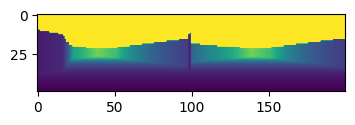

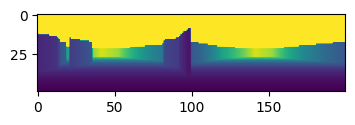

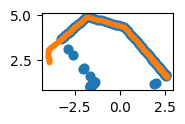

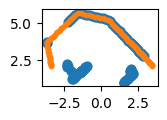

In [50]:
i = 20
j = 15

# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[i,:,:,2],Ys[i,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[j,:,:,2],Ys[j,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.gca().set_aspect(1)
plt.scatter(Xs[i,Xs.shape[1]//2,:,0],Xs[i,Xs.shape[1]//2,:,2], s=40);
plt.scatter(Ys[i,Xs.shape[1]//2,:,0],Ys[i,Xs.shape[1]//2,:,2], s=10);

# ----------
plt.figure(figsize=(4,1))
plt.gca().set_aspect(1)
plt.scatter(Xs[j,Xs.shape[1]//2,:,0],Xs[j,Xs.shape[1]//2,:,2], s=40);
plt.scatter(Ys[j,Xs.shape[1]//2,:,0],Ys[j,Xs.shape[1]//2,:,2], s=10);


In [53]:
sig     = 0.2
outlier = 0.0


X = Xs[i]
a, a_ = eval_baseline(X, Xs, sig, outlier)
b, b_, w_ = eval_constrained(X, Xs, sig, outlier)
c = jnp.array([threedp3_likelihood(X, Y, sig**2, outlier, zmax, w) for Y in Xs])

[<matplotlib.lines.Line2D object at 0x7f97162ac2e0>]

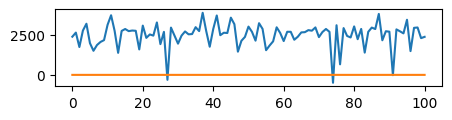

In [54]:
plt.figure(figsize=(5,1))
plt.plot(b - c)
plt.plot(a - c)

[<matplotlib.lines.Line2D object at 0x7fb55ac15450>]

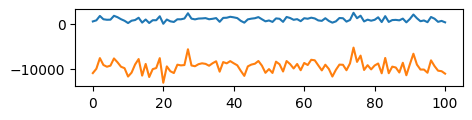

In [41]:
plt.figure(figsize=(5,1))
plt.plot(jnp.sum(b_ + w_, axis=(1,2)) - c)
plt.plot(a - c)

[<matplotlib.lines.Line2D object at 0x7fb55ab8abf0>]

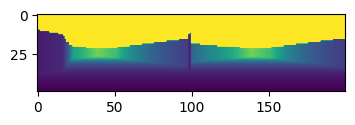

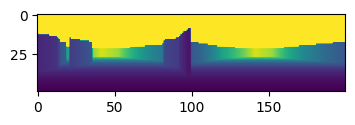

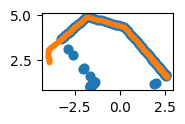

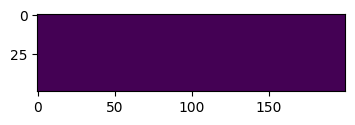

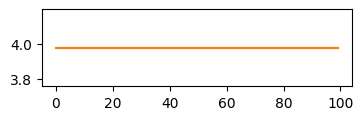

In [42]:

# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[i,:,:,2],Ys[i,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[j,:,:,2],Ys[j,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.gca().set_aspect(1)
plt.scatter(Xs[i,Xs.shape[1]//2,:,0],Xs[i,Xs.shape[1]//2,:,2], s=40);
plt.scatter(Ys[i,Xs.shape[1]//2,:,0],Ys[i,Xs.shape[1]//2,:,2], s=10);

# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([jnp.exp(w_[i]), jnp.exp(w_[j])], axis=1), vmax=4);
# plt.imshow(jnp.concatenate([w_[i], w_[j]], axis=1));
# ----------
plt.figure(figsize=(4,1))
plt.plot(jnp.exp(w_[i,w_.shape[1]//2]))
plt.plot(jnp.exp(w_[j,w_.shape[1]//2]))
# plt.plot(w_[i,w_.shape[1]//2])
# plt.plot(w_[j,w_.shape[1]//2])


3.9788735 3.9788735
3.9788735 3.9788735


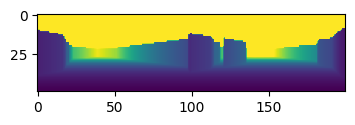

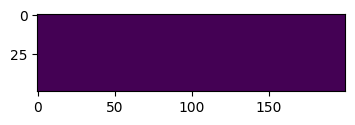

In [43]:
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[i,:,:,2],Xs[j,:,:,2]], axis=1), vmax=5);
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([jnp.exp(w_[i]), jnp.exp(w_[j])], axis=1));
print(jnp.min(jnp.exp(w_[i])), jnp.max(jnp.exp(w_[i])))
print(jnp.min(jnp.exp(w_[j])), jnp.max(jnp.exp(w_[j])))